In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [ ]:
# Download pretrain Efficient model
!gdown https://drive.google.com/uc?id=1f5nHC5A_H9YqbdxYHrDkwLl8lQsDN5rH&export=download

Downloading...
From (original): https://drive.google.com/uc?id=1f5nHC5A_H9YqbdxYHrDkwLl8lQsDN5rH
From (redirected): https://drive.google.com/uc?id=1f5nHC5A_H9YqbdxYHrDkwLl8lQsDN5rH&confirm=t&uuid=48cef705-9cab-411f-9230-f846b9e0ac25
To: /content/EfficientNetB5_2cl_benign_malignant_batch32_(150, 150).h5
100% 276M/276M [00:05<00:00, 46.9MB/s]


In [ ]:
# Download pretrain XCeption model
!gdown https://drive.google.com/uc?id=1zYwRv0u3dyUweX-gMQBpkRKGtZsTy1kw&export=download



Downloading...
From (original): https://drive.google.com/uc?id=1zYwRv0u3dyUweX-gMQBpkRKGtZsTy1kw
From (redirected): https://drive.google.com/uc?id=1zYwRv0u3dyUweX-gMQBpkRKGtZsTy1kw&confirm=t&uuid=8401769d-6acc-4d6f-b503-16260e59f181
To: /content/NoUnfreeze_Xception_150_Xception_2cl_benign_malignant_batch8_(150, 150).h5
100% 245M/245M [00:03<00:00, 75.7MB/s]


In [ ]:
# Download pretrain ResNet model
!gdown https://drive.google.com/uc?id=1aC2KUobcfvx-L3iRlTGxD2x8m9L2sUrh&export=download

Downloading...
From (original): https://drive.google.com/uc?id=1aC2KUobcfvx-L3iRlTGxD2x8m9L2sUrh
From (redirected): https://drive.google.com/uc?id=1aC2KUobcfvx-L3iRlTGxD2x8m9L2sUrh&confirm=t&uuid=5391bb62-b896-4bff-9146-346b58ed9841
To: /content/NoUnfreeze_Resnet50_150_resnet50_2cl_benign_malignant_batch32_(150, 150).h5
100% 256M/256M [00:04<00:00, 53.4MB/s]


In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.6 MB/s eta 0:00:00


In [ ]:
!gdown https://drive.google.com/uc?id=1-6MAWL3pHUEz-f6bSsy2yPYJW4FrI5nt&export=download

Downloading...
From (original): https://drive.google.com/uc?id=1-6MAWL3pHUEz-f6bSsy2yPYJW4FrI5nt
From (redirected): https://drive.google.com/uc?id=1-6MAWL3pHUEz-f6bSsy2yPYJW4FrI5nt&confirm=t&uuid=2bd0baac-bf1b-40af-bfb9-ddc22ae11d90
To: /content/noaugmentation_benign_malignant.pkl
100% 542M/542M [00:06<00:00, 85.4MB/s]


In [ ]:
# Download dataset
!gdown https://drive.google.com/uc?id=1dbzxIeDEM18ll4aTO6CjWHLCJKtGAS-A&export=download

Downloading...
From (original): https://drive.google.com/uc?id=1dbzxIeDEM18ll4aTO6CjWHLCJKtGAS-A
From (redirected): https://drive.google.com/uc?id=1dbzxIeDEM18ll4aTO6CjWHLCJKtGAS-A&confirm=t&uuid=98150af8-4de3-478c-85dc-28cbba176c49
To: /content/CBIS_DDSM.zip
100% 2.42G/2.42G [00:31<00:00, 77.1MB/s]


In [ ]:
# Unzip dataset
!unzip -qq CBIS_DDSM.zip
!rm CBIS_DDSM.zip

In [ ]:
import pickle
import numpy as np
import cv2
import statistics
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model


In [ ]:
# Common hyperparams
common_hyperparams = {
    "model_type": "2cl_benign_malignant",
    "batch_size": 32,
    "epochs": 35,
    "augment_factor": 1,
    "lr": 1e-2,
    "unfreeze_layer": -33,
    "stop_patience": 7,
    "reduce_patience": 7,
    "test_code": False
}


In [ ]:
if (common_hyperparams["model_type"] == "2cl_benign_malignant"):
  categories = ["Benign", "Malignant"]
elif (common_hyperparams["model_type"] == "2cl_mass_calcalcification"):
  categories = ["Mass", "Calcalcification"]
elif (common_hyperparams["model_type"] == "4cl"):
  categories = ["Mass benign", "Mass malignant", "Calcification benign", "Calcification malignant"]

In [ ]:
data_pkl = "/content/noaugmentation_benign_malignant.pkl"
input_size = (150, 150)

In [ ]:
# Load the data from the pickle file
with open(data_pkl, 'rb') as data_file:
    loaded_data = pickle.load(data_file)

# Extract the individual components from the loaded data
new_train_images = loaded_data['new_train_images']
new_train_labels = loaded_data['new_train_labels']
new_train_labels_raw = loaded_data['new_train_labels_raw']
new_test_images = loaded_data['new_test_images']
new_test_labels = loaded_data['new_test_labels']
new_test_labels_raw = loaded_data['new_test_labels_raw']

print("----- Load saved data successfully -----")

----- Load saved data successfully -----


In [ ]:
# Number of images
n_train_img = new_train_images.shape[0]
n_test_img = new_test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = new_train_images.shape[1]
img_h = new_train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

if (np.max(new_train_images) != 255.0):
  raise Exception(f"Image pixel scale before data generation must be from 0 - 255")



# Replicate the only color channel (gray) 3 times, for ResNet compatibility
new_train_images = np.repeat(new_train_images, 3, axis=3)
new_test_images = np.repeat(new_test_images, 3, axis=3)



# Resize all image
if (new_train_images.shape[1] != input_size[0]):
  resized_images = np.empty((new_train_images.shape[0], input_size[0], input_size[1], 3))

  print("Resize train images")
  # Loop through each image and resize it
  for i in range(new_train_images.shape[0]):
    resized_img  = cv2.resize(new_train_images[i].copy(), input_size)
    resized_images[i] = resized_img

  new_train_images = resized_images
  print("New train image shape: ", new_train_images.shape)


if (new_test_images.shape[1] != input_size[0]):
  resized_images = np.empty((new_test_images.shape[0], input_size[0], input_size[1], 3))

  print("Resize test images")
  # Loop through each image and resize it
  for i in range(new_test_images.shape[0]):
    resized_img = cv2.resize(new_test_images[i].copy(), input_size)
    resized_images[i] = resized_img
  new_test_images = resized_images
  print("New test image shape: ", new_test_images.shape)

print("**************", np.max(new_test_images))

print("333333333333333333333333333333333333333333333333333333333")

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
new_train_images = new_train_images[perm]
new_train_labels = new_train_labels[perm]

print("44444444444444444444444444444444444444444444444444444")


Train size: 2676 	 Test size: 336
Image size: 150x150
************** 255.0
333333333333333333333333333333333333333333333333333333333
44444444444444444444444444444444444444444444444444444


In [ ]:
print("77777777777777777777777777777777777777777777")

# test_datagen = ImageDataGenerator(
#       preprocessing_function=preprocess_input,
#     )
# test_generator = test_datagen.flow(new_test_images, new_test_labels, batch_size=common_hyperparams["batch_size"])
new_test_images_efficientnet = new_test_images.copy()
tf.keras.applications.efficientnet.preprocess_input(new_test_images_efficientnet)


new_test_images_xception = new_test_images.copy()
tf.keras.applications.xception.preprocess_input(new_test_images_xception)


new_test_images_resnet = new_test_images.copy()
tf.keras.applications.resnet50.preprocess_input(new_test_images_resnet)

tf.keras.applications.resnet50.preprocess_input(new_test_images)


print("*********preprocess*****", np.max(new_test_images))


print("----- Done generating images -----")


77777777777777777777777777777777777777777777
*********preprocess***** 151.061
----- Done generating images -----


In [ ]:
!pip install tensorflow-addons


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

# Register the Lookahead optimizer as a custom object
tf.keras.utils.get_custom_objects().update({'Lookahead': tfa.optimizers.Lookahead})

from tensorflow_addons.optimizers import AdamW, Lookahead

# Register the AdamW optimizer as a custom object
tf.keras.utils.get_custom_objects().update({'AdamW': AdamW})

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Load the pre-trained models
base_model1 = load_model('/content/EfficientNetB5_2cl_benign_malignant_batch32_(150, 150).h5')
base_model2 = load_model('/content/NoUnfreeze_Xception_150_Xception_2cl_benign_malignant_batch8_(150, 150).h5')
base_model3 = load_model('/content/NoUnfreeze_Resnet50_150_resnet50_2cl_benign_malignant_batch32_(150, 150).h5')


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(new_test_labels_raw, predicted_labels):

  accuracy = accuracy_score(new_test_labels_raw, predicted_labels)
  print("Accuracy:", accuracy)
  f1 = f1_score(new_test_labels_raw, predicted_labels)
  precision = precision_score(new_test_labels_raw, predicted_labels)
  recall = recall_score(new_test_labels_raw, predicted_labels)
  print("F1 Score:", f1)
  print("Precision:", precision)
  print("Recall:", recall)

  # Create a confusion matrix
  conf_matrix = confusion_matrix(new_test_labels_raw, predicted_labels)

  # Create a heatmap to visualize the confusion matrix
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

## EfficientNetB5 Evaluation

In [ ]:
base_model1.summary()

Model: "EfficientNetB5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 150, 150, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 150, 150, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 150, 150, 3)          0         ['normalization_1

In [ ]:
base_model2.summary()

Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]

In [ ]:
base_model3.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
efficientnet_last_layer = [layer.name for layer in base_model1.layers if layer.name.startswith('conv2d')][-1]
xception_last_layer = [layer.name for layer in base_model2.layers if layer.name.startswith('conv2d')][-1]
resnet_last_layer = [layer.name for layer in base_model3.layers if layer.name.startswith('conv2d')][-1]
print(efficientnet_last_layer)
print(xception_last_layer)
print(resnet_last_layer)

conv2d_15
conv2d_11
conv2d_7


11/11 [==============================] - 65s 6s/step
Accuracy: 0.6309523809523809
F1 Score: 0.5602836879432624
Precision: 0.47878787878787876
Recall: 0.6752136752136753


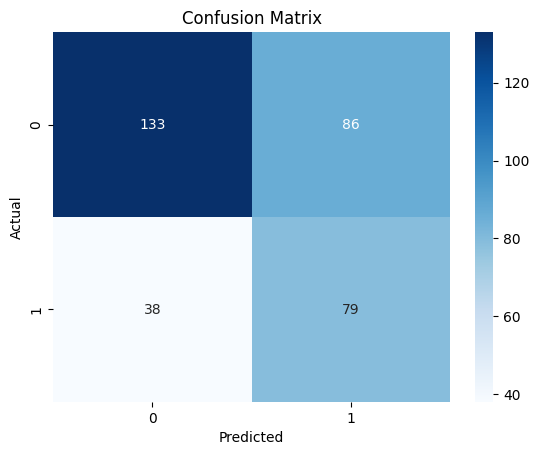

In [ ]:
# Make predictions on the test data
test_predictions_efficientnet = base_model1.predict(new_test_images_efficientnet)

# Convert the predictions to class labels (0 or 1)
predicted_labels_efficientnet = np.argmax(test_predictions_efficientnet, axis=1)

evaluate(new_test_labels_raw, predicted_labels_efficientnet)

11/11 [==============================] - 41s 4s/step
Accuracy: 0.6339285714285714
F1 Score: 0.6019417475728156
Precision: 0.484375
Recall: 0.7948717948717948


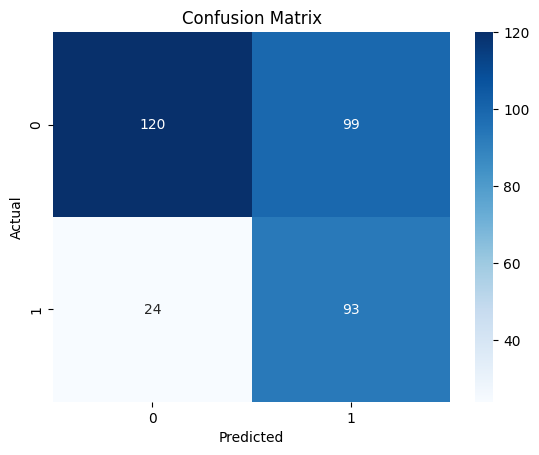

In [ ]:
# Make predictions on the test data
test_predictions_xception = base_model2.predict(new_test_images_xception)

# Convert the predictions to class labels (0 or 1)
predicted_labels_xception = np.argmax(test_predictions_xception, axis=1)

evaluate(new_test_labels_raw, predicted_labels_xception)

11/11 [==============================] - 38s 3s/step
Accuracy: 0.6815476190476191
F1 Score: 0.5803921568627451
Precision: 0.5362318840579711
Recall: 0.6324786324786325


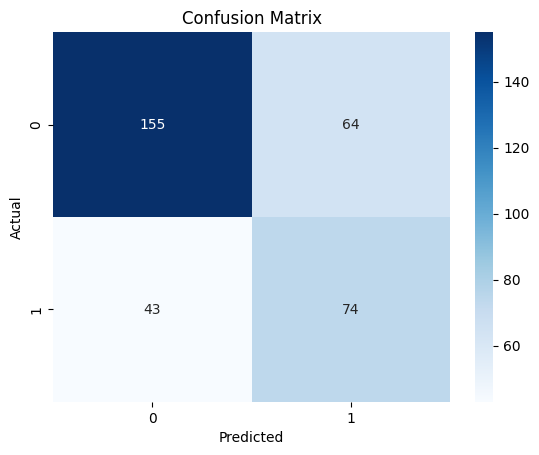

In [ ]:
# Make predictions on the test data
test_predictions_resnet = base_model3.predict(new_test_images_resnet)

# Convert the predictions to class labels (0 or 1)
predicted_labels_resnet = np.argmax(test_predictions_resnet, axis=1)

evaluate(new_test_labels_raw, predicted_labels_resnet)

In [ ]:
# Find indices where all three models make the same prediction
same_prediction_indices = []

for i in range(len(predicted_labels_efficientnet)):
    if predicted_labels_efficientnet[i] == predicted_labels_xception[i] == predicted_labels_resnet[i]:
        same_prediction_indices.append(i)

print("Indices of test images with the same prediction across all three models:", same_prediction_indices)

Indices of test images with the same prediction across all three models: [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 28, 29, 30, 32, 35, 36, 41, 43, 45, 46, 47, 48, 53, 56, 60, 61, 64, 65, 66, 67, 68, 69, 73, 74, 75, 76, 78, 79, 84, 86, 87, 89, 92, 93, 94, 95, 96, 99, 100, 101, 102, 104, 105, 107, 108, 109, 111, 116, 117, 118, 120, 122, 125, 126, 127, 128, 129, 130, 131, 132, 136, 137, 138, 142, 143, 145, 146, 148, 150, 151, 152, 153, 154, 157, 159, 160, 161, 163, 164, 166, 167, 169, 170, 171, 172, 173, 175, 177, 181, 182, 185, 186, 187, 188, 190, 191, 197, 201, 204, 206, 207, 209, 210, 211, 213, 216, 217, 218, 219, 220, 221, 222, 224, 225, 226, 228, 229, 236, 237, 238, 241, 242, 243, 244, 245, 247, 248, 249, 250, 260, 261, 262, 264, 265, 266, 267, 268, 269, 270, 271, 272, 275, 278, 280, 283, 284, 287, 288, 289, 290, 291, 292, 293, 294, 295, 299, 304, 305, 308, 311, 312, 313, 314, 316, 317, 318, 319, 320, 322, 324, 325, 328, 330, 334, 335]


In [ ]:
def rescale_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    scaled_image = (image - min_val) / (max_val - min_val) * 255
    return scaled_image.astype(np.float32)

In [ ]:
for i, label in enumerate(new_test_labels):
  print(f"{i} : {label}")
  if (i== 100):
    break

0 : [0. 1.]
1 : [0. 1.]
2 : [0. 1.]
3 : [0. 1.]
4 : [1. 0.]
5 : [1. 0.]
6 : [0. 1.]
7 : [0. 1.]
8 : [1. 0.]
9 : [0. 1.]
10 : [0. 1.]
11 : [1. 0.]
12 : [1. 0.]
13 : [0. 1.]
14 : [0. 1.]
15 : [0. 1.]
16 : [0. 1.]
17 : [0. 1.]
18 : [0. 1.]
19 : [1. 0.]
20 : [1. 0.]
21 : [1. 0.]
22 : [1. 0.]
23 : [1. 0.]
24 : [0. 1.]
25 : [0. 1.]
26 : [1. 0.]
27 : [1. 0.]
28 : [1. 0.]
29 : [1. 0.]
30 : [1. 0.]
31 : [1. 0.]
32 : [1. 0.]
33 : [1. 0.]
34 : [1. 0.]
35 : [1. 0.]
36 : [1. 0.]
37 : [1. 0.]
38 : [1. 0.]
39 : [0. 1.]
40 : [0. 1.]
41 : [0. 1.]
42 : [0. 1.]
43 : [1. 0.]
44 : [1. 0.]
45 : [1. 0.]
46 : [1. 0.]
47 : [0. 1.]
48 : [0. 1.]
49 : [1. 0.]
50 : [1. 0.]
51 : [0. 1.]
52 : [0. 1.]
53 : [0. 1.]
54 : [1. 0.]
55 : [1. 0.]
56 : [1. 0.]
57 : [1. 0.]
58 : [1. 0.]
59 : [1. 0.]
60 : [0. 1.]
61 : [0. 1.]
62 : [0. 1.]
63 : [0. 1.]
64 : [1. 0.]
65 : [1. 0.]
66 : [1. 0.]
67 : [1. 0.]
68 : [1. 0.]
69 : [1. 0.]
70 : [1. 0.]
71 : [0. 1.]
72 : [0. 1.]
73 : [1. 0.]
74 : [1. 0.]
75 : [1. 0.]
76 : [1. 0.]
77 : [1. 

----- Visualize one image from the test set and its label, just to make sure the data format is correct -----
[[ -34.68  -68.68  -51.68 ...  -46.68  -85.68  -76.68]
 [ -30.68  -46.68  -26.68 ...  -42.68  -71.68  -62.68]
 [   0.32  -40.68  -37.68 ...  -39.68  -34.68  -49.68]
 ...
 [ -33.68  -40.68  -56.68 ... -102.68 -101.68 -103.68]
 [ -35.68  -41.68  -46.68 ...  -93.68 -107.68 -102.68]
 [ -49.68  -49.68  -59.68 ... -108.68 -114.68 -115.68]]


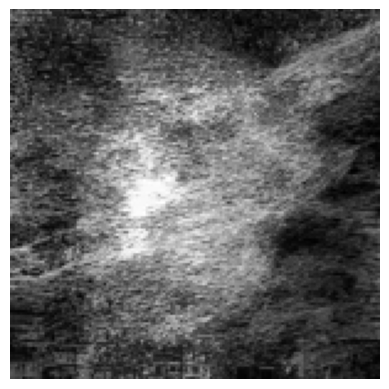

Label: [1. 0.]
1/1 [==============================] - 0s 276ms/step
EfficientNet Prediction: [[0.18251355 0.81748646]]
EfficientNet Predicted class index: 1


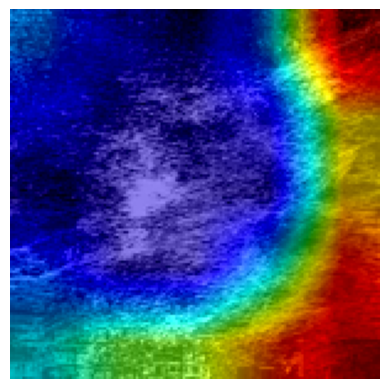

1/1 [==============================] - 0s 193ms/step
Xception Prediction: [[0.26423755 0.7357625 ]]
Xception Predicted class index: 1


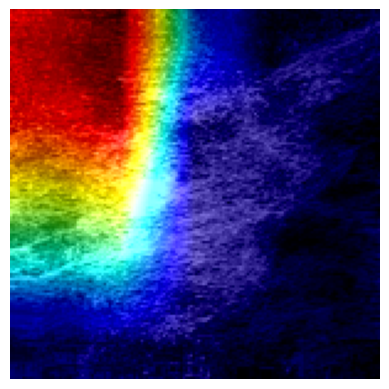

1/1 [==============================] - 0s 139ms/step
ResNet Prediction: [[0.2379749 0.7620251]]
ResNet Predicted class index: 1


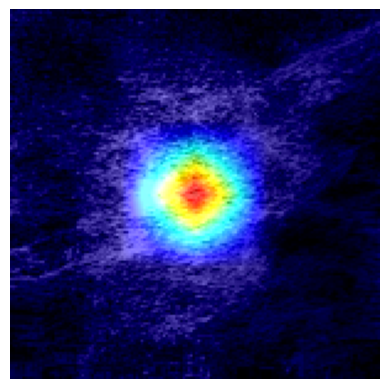

In [ ]:
idx = 100
test_image = new_test_images[idx]

print("----- Visualize one image from the test set and its label, just to make sure the data format is correct -----")
print(test_image[:,:,0])
# plt.figure(figsize=(10, 10))
plt.imshow(test_image[:,:,0], cmap='gray')

plt.axis('off')
plt.show()

print("Label: " + str(new_test_labels[idx]))



def explain(model_name, base_model, input_image, plot_image, extract_layer):

  img_array = tf.expand_dims(input_image, axis=0)
  preds = base_model.predict(img_array)
  print(f"{model_name} Prediction:", preds)

  class_idx = np.argmax(preds[0])
  print(f"{model_name} Predicted class index:", class_idx)

  # Modify the model to output both last conv layer output and final predictions
  last_conv_layer_name = extract_layer  # Make sure this is your target conv layer
  last_conv_layer = base_model.get_layer(last_conv_layer_name)
  model_for_gradcam = Model(inputs=base_model.inputs, outputs=[last_conv_layer.output, base_model.output])

  # Apply Gradient Tape
  with tf.GradientTape() as tape:
      # Ensure to use img_array which has the batch dimension
      conv_outputs, predictions = model_for_gradcam(img_array)
      # Using predictions to compute loss, which will be used to calculate gradients
      loss = predictions[:, class_idx]

  # Compute gradients
  grads = tape.gradient(loss, conv_outputs)
  # Pooling and weighting gradients
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
  pooled_grads_expanded = tf.reshape(pooled_grads, [1, 1, 1, pooled_grads.shape[0]])
  modified_conv_outputs = conv_outputs * pooled_grads_expanded
  heatmap = tf.reduce_mean(modified_conv_outputs, axis=-1)

  # Heatmap post-processing
  heatmap = np.maximum(heatmap[0].numpy(), 0) / np.max(heatmap[0].numpy())
  heatmap = cv2.resize(heatmap, (test_image.shape[1], test_image.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  # Superimposing the heatmap with the original image
  # Since test_image was resized and converted to float32 for model input, we need to ensure it's in the original uint8 format for visualization
  superimposed_img = heatmap * 0.9 + plot_image
  superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

  # Displaying the superimposed image
  # plt.figure(figsize=(10, 10))
  plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

explain("EfficientNet", base_model1, new_test_images_efficientnet[idx], new_test_images[idx], efficientnet_last_layer)
explain("Xception", base_model2, new_test_images_xception[idx], new_test_images[idx], xception_last_layer)
explain("ResNet", base_model3, new_test_images_resnet[idx], new_test_images[idx], resnet_last_layer)